# Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Loading Dataset

In [ ]:
def load_and_prep_cifar(batch_size, shuffle_buffer_size):
  #train, test = tfds.load('cifar10', split=['train','test'], as_supervised=True)
  train_ds, test_ds= tfds.load('cifar10', split=['train','test'] , as_supervised=True)

  def preprocessing_func(img, label):
    img = tf.cast(img, tf.float32)
    img = (img/128)-1
    label = tf.one_hot(label, depth = 10)
    return img, label


  train_ds = train_ds.map(lambda img, label: preprocessing_func(img,label))
  test_ds = test_ds.map(lambda img, label: preprocessing_func(img,label))
  train_ds = train_ds.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(2)
  test_ds = test_ds.batch(batch_size).prefetch(2)
  return train_ds, test_ds

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000

train_ds, test_ds = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)

# Model

In [ ]:
def create_my_cifar_cnn(name= 'my_cnn'):
  inputs= tf.keras.Input(shape= (32,32,3),dtype=tf.float32)

  cnn_layer_1_1= tf.keras.layers.Conv2D(filters = 16, kernel_size=(3,3), activation = 'relu',padding='same', strides=(1,1))
  x= cnn_layer_1_1(inputs)#shape: [batch_size, 32,32,16]

  cnn_layer_1_2= tf.keras.layers.Conv2D(filters = 16, kernel_size=(3,3), activation = 'relu',padding='same', strides=(1,1))
  x= cnn_layer_1_2(x)#shape: [batch_size, 32,32,16]

  cnn_layer_pooling1 = tf.keras.layers.MaxPool2D()
  x= cnn_layer_pooling1(x)#shape: [batch_size, 16,16,16]

  cnn_layer_2_1= tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation = 'relu',padding='same', strides=(1,1))
  x= cnn_layer_2_1(x)#shape: [batch_size, 16,16,32]

  cnn_layer_2_2= tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation = 'relu',padding='same', strides=(1,1))
  x= cnn_layer_2_2(x)#shape: [batch_size, 16,16,32]

  cnn_layer_pooling2 = tf.keras.layers.MaxPool2D()
  x= cnn_layer_pooling2(x)#shape: [batch_size, 8,8,32]

  cnn_layer_3_1= tf.keras.layers.Conv2D(filters = 64, kernel_size=(3,3), activation = 'relu',padding='same', strides=(1,1))
  x= cnn_layer_3_1(x)#shape: [batch_size, 8,8,64]

  cnn_layer_3_2= tf.keras.layers.Conv2D(filters = 64, kernel_size=(3,3), activation = 'relu',padding='same', strides=(1,1))
  x= cnn_layer_3_2(x)#shape: [batch_size, 8,8,64]

  cnn_layer_flatten = tf.keras.layers.Flatten()
  x= cnn_layer_flatten(x)# shape: [batch_size, 4096]


  output_layer = tf.keras.layers.Dense(10, activation = 'softmax')
  output = output_layer(x)#shape: [batch_size, 10]

  model = tf.keras.Model(inputs , output, name=name)

  return model

In [ ]:
# Define a function to create the modular CNN model
def create_modular_cifar_cnn(name="name", number_of_blocks=3, first_block_filters=16, cnns_per_block=2, number_dense_layers=2):
    # Set the initial number of filters
    filters = first_block_filters

    # Define the input layer with a shape of (32, 32, 3) for CIFAR-10 images
    inputs = tf.keras.Input(shape=(32, 32, 3), dtype=tf.float32)
    x = inputs  # Assign the input to a variable 'x'

    # Create CNN layers in blocks with maxpooling after each block
    for i in range(number_of_blocks):
        for j in range(cnns_per_block):
            # Add Conv2D layer with specified filters, kernel size, activation function, and padding
            x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), activation='relu', padding='same')(x)

        # Add MaxPooling2D layer after each block
        x = tf.keras.layers.MaxPool2D()(x)

        # Double the number of filters for the next block
        filters *= 2

    # Flatten the output for dense layers
    x = tf.keras.layers.Flatten()(x)
    number_of_neurons = x.shape[1]

    # Create dense layers
    for i in range(number_dense_layers):
        # Add Dense layer with the specified number of neurons and activation function
        x = tf.keras.layers.Dense(number_of_neurons, activation='relu')(x)
        # Halve the number of neurons for the next dense layer
        number_of_neurons //= 2

    # Output layer with 10 neurons (for 10 classes in CIFAR-10) and softmax activation
    output = tf.keras.layers.Dense(10, activation='softmax')(x)

    # Create and summarize the model
    model = tf.keras.Model(inputs, output, name=name)
    model.summary()

    return model  # Return the created model

#Train_Model

In [ ]:

LR= 0.001
NUM_EPOCHS=50

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']

In [ ]:
def train_cifar_10(model, train_ds, test_ds, num_epochs, lr, optimizer):
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    train_loss = tf.keras.metrics.CategoricalCrossentropy(name='train_loss')
    train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
    test_loss = tf.keras.metrics.CategoricalCrossentropy(name='test_loss')
    test_accuracy = tf.keras.metrics.CategoricalAccuracy(name="test_accuracy")

    model.compile(optimizer=optimizer,
              loss=loss_object,
              metrics=['accuracy', 'categorical_accuracy'])

    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []


    @tf.function
    def train_step(images, labels):
        with tf.GradientTape() as tape:
            predictions = model(images)
            loss = loss_object(labels, predictions)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss.update_state(labels, predictions)
        train_accuracy.update_state(labels, predictions)

    @tf.function
    def test_step(images, labels):
        predictions = model(images)
        t_loss = loss_object(labels, predictions)

        test_loss.update_state(labels, predictions)
        test_accuracy.update_state(labels, predictions)

    for epoch in range(num_epochs):
        # Training loop
        for images, labels in train_ds:
            train_step(images, labels)

        # Testing loop
        for test_images, test_labels in test_ds:
            test_step(test_images, test_labels)

        # Save metrics for plotting
        train_losses.append(train_loss.result().numpy())
        train_accuracies.append(train_accuracy.result().numpy())
        test_losses.append(test_loss.result().numpy())
        test_accuracies.append(test_accuracy.result().numpy())

        template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'
        print(template.format(epoch + 1,
                              train_loss.result(),
                              train_accuracy.result() * 100,
                              test_loss.result(),
                              test_accuracy.result() * 100))

        # Reset the metrics for the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()


    # Plotting
    plt.figure(figsize=(12, 4))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.title('Training and Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()





In [ ]:
  # Train the model using the defined function




LR1 = 0.001

LR2 = 0.0001


model1_architecture1_1 = create_modular_cifar_cnn(name="cifar_cnn_model", number_of_blocks=2, first_block_filters=12, cnns_per_block=5, number_dense_layers=1)

model1_architecture1_2 = create_modular_cifar_cnn(name="cifar_cnn_model", number_of_blocks=2, first_block_filters=12, cnns_per_block=5, number_dense_layers=1)

model1_architecture1_3 = create_modular_cifar_cnn(name="cifar_cnn_model", number_of_blocks=2, first_block_filters=12, cnns_per_block=5, number_dense_layers=1)

model1_architecture1_4 = create_modular_cifar_cnn(name="cifar_cnn_model", number_of_blocks=2, first_block_filters=12, cnns_per_block=5, number_dense_layers=1)

model2_architecture2_1 = create_modular_cifar_cnn(name="cifar_cnn_model", number_of_blocks=3, first_block_filters=32, cnns_per_block=2, number_dense_layers=2)

model2_architecture2_2 = create_modular_cifar_cnn(name="cifar_cnn_model", number_of_blocks=3, first_block_filters=32, cnns_per_block=2, number_dense_layers=2)

model2_architecture2_3 = create_modular_cifar_cnn(name="cifar_cnn_model", number_of_blocks=3, first_block_filters=32, cnns_per_block=2, number_dense_layers=2)

model2_architecture2_4 = create_modular_cifar_cnn(name="cifar_cnn_model", number_of_blocks=3, first_block_filters=32, cnns_per_block=2, number_dense_layers=2)


# Define learning rates
LR1 = 0.001
LR2 = 0.01

# Define optimizers
adam1_1 = tf.keras.optimizers.Adam(learning_rate=LR1)
adam1_2 = tf.keras.optimizers.Adam(learning_rate=LR2)

adam2_1 = tf.keras.optimizers.Adam(learning_rate=LR1)
adam2_2 = tf.keras.optimizers.Adam(learning_rate=LR2)

SGD1_1 = tf.keras.optimizers.SGD(learning_rate=LR1)
SGD1_2 = tf.keras.optimizers.SGD(learning_rate=LR2)

SGD2_1 = tf.keras.optimizers.SGD(learning_rate=LR1)
SGD2_2 = tf.keras.optimizers.SGD(learning_rate=LR2)


Model: "cifar_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_128 (Conv2D)         (None, 32, 32, 12)        336       
                                                                 
 conv2d_129 (Conv2D)         (None, 32, 32, 12)        1308      
                                                                 
 conv2d_130 (Conv2D)         (None, 32, 32, 12)        1308      
                                                                 
 conv2d_131 (Conv2D)         (None, 32, 32, 12)        1308      
                                                                 
 conv2d_132 (Conv2D)         (None, 32, 32, 12)        1308      
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 16, 16, 12)    


# Train models with different architectures, learning rates, and optimizers

Epoch 1, Loss: 1.5563, Accuracy: 42.92%, Test Loss: 1.2739, Test Accuracy: 53.67%
Epoch 2, Loss: 1.1558, Accuracy: 58.74%, Test Loss: 1.0461, Test Accuracy: 62.97%
Epoch 3, Loss: 0.9488, Accuracy: 66.34%, Test Loss: 0.9564, Test Accuracy: 66.42%
Epoch 4, Loss: 0.7769, Accuracy: 72.61%, Test Loss: 0.9206, Test Accuracy: 69.21%
Epoch 5, Loss: 0.6103, Accuracy: 78.40%, Test Loss: 0.9717, Test Accuracy: 69.25%
Epoch 6, Loss: 0.4358, Accuracy: 84.72%, Test Loss: 1.2194, Test Accuracy: 66.95%
Epoch 7, Loss: 0.2842, Accuracy: 90.15%, Test Loss: 1.5205, Test Accuracy: 67.19%
Epoch 8, Loss: 0.1795, Accuracy: 93.81%, Test Loss: 1.8106, Test Accuracy: 67.43%
Epoch 9, Loss: 0.1481, Accuracy: 94.94%, Test Loss: 1.7866, Test Accuracy: 68.52%
Epoch 10, Loss: 0.1152, Accuracy: 96.10%, Test Loss: 1.8473, Test Accuracy: 68.61%
Epoch 11, Loss: 0.0926, Accuracy: 96.83%, Test Loss: 1.9800, Test Accuracy: 67.61%
Epoch 12, Loss: 0.0817, Accuracy: 97.11%, Test Loss: 1.9299, Test Accuracy: 68.71%
Epoch 13, Los

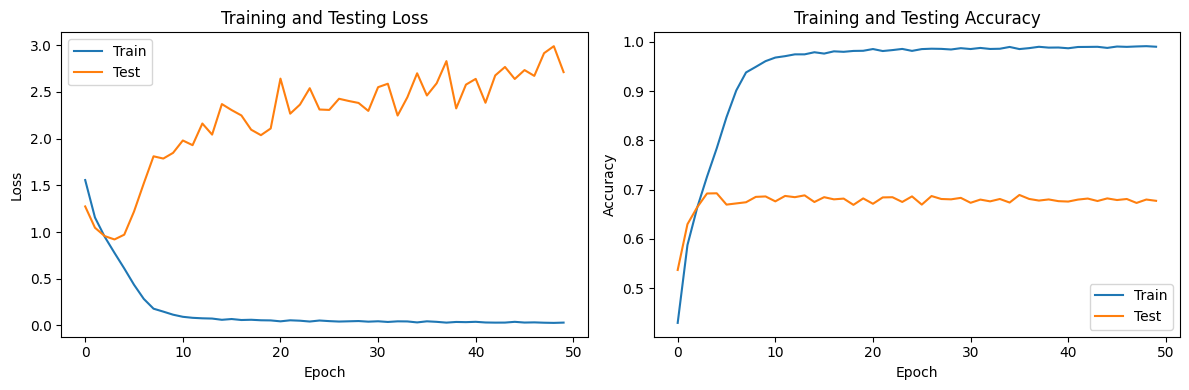

In [ ]:
# Architecture 1, Learning Rate 1, Optimizer 1
train_cifar_10(model1_architecture1_1, train_ds, test_ds, NUM_EPOCHS, LR1, adam1_1)  # Setting 1

Epoch 1, Loss: 2.3026, Accuracy: 11.83%, Test Loss: 2.3023, Test Accuracy: 12.38%
Epoch 2, Loss: 2.3021, Accuracy: 13.87%, Test Loss: 2.3019, Test Accuracy: 14.15%
Epoch 3, Loss: 2.3018, Accuracy: 15.08%, Test Loss: 2.3016, Test Accuracy: 14.88%
Epoch 4, Loss: 2.3014, Accuracy: 15.77%, Test Loss: 2.3012, Test Accuracy: 15.60%
Epoch 5, Loss: 2.3010, Accuracy: 16.19%, Test Loss: 2.3007, Test Accuracy: 15.88%
Epoch 6, Loss: 2.3005, Accuracy: 16.57%, Test Loss: 2.3002, Test Accuracy: 16.29%
Epoch 7, Loss: 2.2999, Accuracy: 16.72%, Test Loss: 2.2995, Test Accuracy: 16.45%
Epoch 8, Loss: 2.2993, Accuracy: 17.03%, Test Loss: 2.2988, Test Accuracy: 16.74%
Epoch 9, Loss: 2.2984, Accuracy: 17.30%, Test Loss: 2.2978, Test Accuracy: 17.16%
Epoch 10, Loss: 2.2973, Accuracy: 17.91%, Test Loss: 2.2965, Test Accuracy: 17.74%
Epoch 11, Loss: 2.2959, Accuracy: 18.59%, Test Loss: 2.2948, Test Accuracy: 18.48%
Epoch 12, Loss: 2.2939, Accuracy: 19.30%, Test Loss: 2.2924, Test Accuracy: 19.43%
Epoch 13, Los

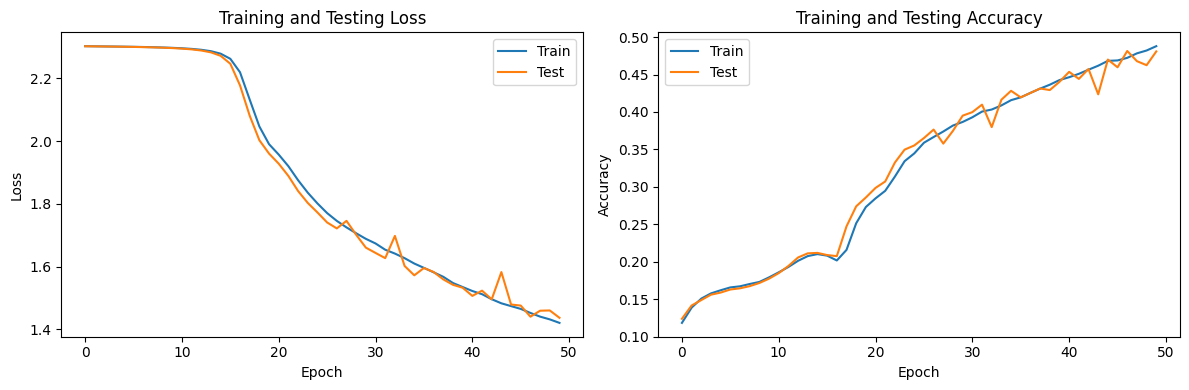

In [ ]:
# Architecture 1, Learning Rate 1, Optimizer 2
train_cifar_10(model1_architecture1_2, train_ds, test_ds, NUM_EPOCHS, LR1, SGD1_1)  # Setting 2

Epoch 1, Loss: 2.3447, Accuracy: 9.73%, Test Loss: 2.3035, Test Accuracy: 10.00%
Epoch 2, Loss: 2.3033, Accuracy: 9.78%, Test Loss: 2.3036, Test Accuracy: 10.00%
Epoch 3, Loss: 2.3034, Accuracy: 9.77%, Test Loss: 2.3035, Test Accuracy: 10.00%
Epoch 4, Loss: 2.3034, Accuracy: 9.97%, Test Loss: 2.3038, Test Accuracy: 10.00%
Epoch 5, Loss: 2.3032, Accuracy: 9.98%, Test Loss: 2.3035, Test Accuracy: 10.00%
Epoch 6, Loss: 2.3033, Accuracy: 9.90%, Test Loss: 2.3035, Test Accuracy: 10.00%
Epoch 7, Loss: 2.3034, Accuracy: 9.98%, Test Loss: 2.3037, Test Accuracy: 10.00%
Epoch 8, Loss: 2.3034, Accuracy: 9.77%, Test Loss: 2.3036, Test Accuracy: 10.00%
Epoch 9, Loss: 2.3033, Accuracy: 9.98%, Test Loss: 2.3034, Test Accuracy: 10.00%
Epoch 10, Loss: 2.3033, Accuracy: 9.96%, Test Loss: 2.3037, Test Accuracy: 10.00%
Epoch 11, Loss: 2.3033, Accuracy: 9.94%, Test Loss: 2.3037, Test Accuracy: 10.00%
Epoch 12, Loss: 2.3034, Accuracy: 9.80%, Test Loss: 2.3036, Test Accuracy: 10.00%
Epoch 13, Loss: 2.3033, A

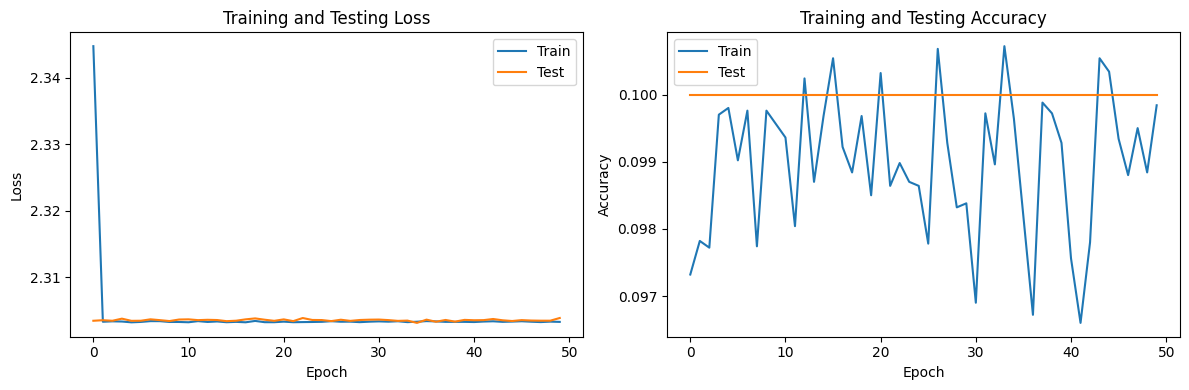

In [ ]:
# Architecture 1, Learning Rate 2, Optimizer 1
train_cifar_10(model1_architecture1_3, train_ds, test_ds, NUM_EPOCHS, LR2, adam1_2)  # Setting 3

Epoch 1, Loss: 2.3012, Accuracy: 13.57%, Test Loss: 2.2994, Test Accuracy: 22.30%
Epoch 2, Loss: 2.2953, Accuracy: 19.01%, Test Loss: 2.2872, Test Accuracy: 22.03%
Epoch 3, Loss: 2.1666, Accuracy: 23.10%, Test Loss: 2.0354, Test Accuracy: 27.15%
Epoch 4, Loss: 1.9092, Accuracy: 31.30%, Test Loss: 1.8790, Test Accuracy: 31.68%
Epoch 5, Loss: 1.7413, Accuracy: 37.26%, Test Loss: 1.6984, Test Accuracy: 36.94%
Epoch 6, Loss: 1.6087, Accuracy: 42.00%, Test Loss: 1.7144, Test Accuracy: 39.37%
Epoch 7, Loss: 1.5078, Accuracy: 45.63%, Test Loss: 1.6826, Test Accuracy: 42.15%
Epoch 8, Loss: 1.4304, Accuracy: 48.69%, Test Loss: 1.4775, Test Accuracy: 46.01%
Epoch 9, Loss: 1.3590, Accuracy: 51.32%, Test Loss: 1.4034, Test Accuracy: 50.00%
Epoch 10, Loss: 1.2971, Accuracy: 54.06%, Test Loss: 1.4304, Test Accuracy: 49.77%
Epoch 11, Loss: 1.2419, Accuracy: 55.79%, Test Loss: 1.3277, Test Accuracy: 52.52%
Epoch 12, Loss: 1.1918, Accuracy: 57.94%, Test Loss: 1.2932, Test Accuracy: 54.24%
Epoch 13, Los

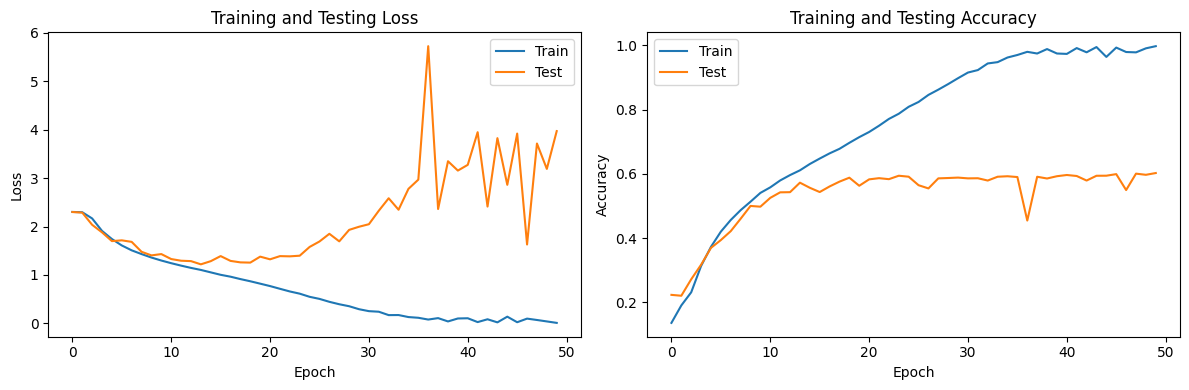

In [ ]:
# Architecture 1, Learning Rate 2, Optimizer 2
train_cifar_10(model1_architecture1_4, train_ds, test_ds, NUM_EPOCHS, LR2, SGD1_2)  # Setting 4

Epoch 1, Loss: 1.4726, Accuracy: 45.27%, Test Loss: 1.1105, Test Accuracy: 59.42%
Epoch 2, Loss: 0.9244, Accuracy: 67.31%, Test Loss: 0.8521, Test Accuracy: 70.49%
Epoch 3, Loss: 0.6974, Accuracy: 75.44%, Test Loss: 0.7737, Test Accuracy: 73.65%
Epoch 4, Loss: 0.5379, Accuracy: 80.93%, Test Loss: 0.7410, Test Accuracy: 76.39%
Epoch 5, Loss: 0.4113, Accuracy: 85.50%, Test Loss: 0.7522, Test Accuracy: 77.68%
Epoch 6, Loss: 0.2951, Accuracy: 89.67%, Test Loss: 0.8590, Test Accuracy: 76.75%
Epoch 7, Loss: 0.2055, Accuracy: 92.70%, Test Loss: 0.9230, Test Accuracy: 76.62%
Epoch 8, Loss: 0.1667, Accuracy: 94.12%, Test Loss: 1.0368, Test Accuracy: 77.01%
Epoch 9, Loss: 0.1344, Accuracy: 95.28%, Test Loss: 1.1266, Test Accuracy: 76.25%
Epoch 10, Loss: 0.1114, Accuracy: 96.29%, Test Loss: 1.0899, Test Accuracy: 77.41%
Epoch 11, Loss: 0.0940, Accuracy: 96.79%, Test Loss: 1.3586, Test Accuracy: 75.34%
Epoch 12, Loss: 0.0818, Accuracy: 97.40%, Test Loss: 1.2512, Test Accuracy: 78.51%
Epoch 13, Los

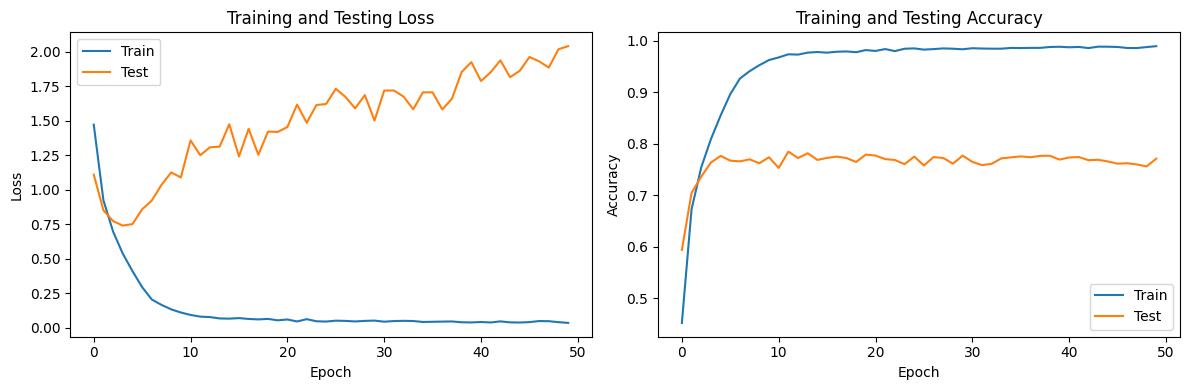

In [ ]:
# Architecture 2, Learning Rate 1, Optimizer 1
train_cifar_10(model2_architecture2_1, train_ds, test_ds, NUM_EPOCHS, LR1, adam2_1)  # Setting 5

Epoch 1, Loss: 2.3011, Accuracy: 11.03%, Test Loss: 2.2999, Test Accuracy: 11.48%
Epoch 2, Loss: 2.2990, Accuracy: 11.69%, Test Loss: 2.2977, Test Accuracy: 11.93%
Epoch 3, Loss: 2.2966, Accuracy: 12.23%, Test Loss: 2.2951, Test Accuracy: 12.68%
Epoch 4, Loss: 2.2936, Accuracy: 13.44%, Test Loss: 2.2914, Test Accuracy: 14.18%
Epoch 5, Loss: 2.2893, Accuracy: 15.39%, Test Loss: 2.2860, Test Accuracy: 16.41%
Epoch 6, Loss: 2.2826, Accuracy: 17.04%, Test Loss: 2.2772, Test Accuracy: 17.80%
Epoch 7, Loss: 2.2715, Accuracy: 17.99%, Test Loss: 2.2624, Test Accuracy: 18.42%
Epoch 8, Loss: 2.2527, Accuracy: 18.33%, Test Loss: 2.2378, Test Accuracy: 19.25%
Epoch 9, Loss: 2.2228, Accuracy: 19.98%, Test Loss: 2.2002, Test Accuracy: 22.31%
Epoch 10, Loss: 2.1785, Accuracy: 23.26%, Test Loss: 2.1459, Test Accuracy: 25.24%
Epoch 11, Loss: 2.1205, Accuracy: 25.35%, Test Loss: 2.0811, Test Accuracy: 26.77%
Epoch 12, Loss: 2.0572, Accuracy: 26.58%, Test Loss: 2.0135, Test Accuracy: 28.20%
Epoch 13, Los

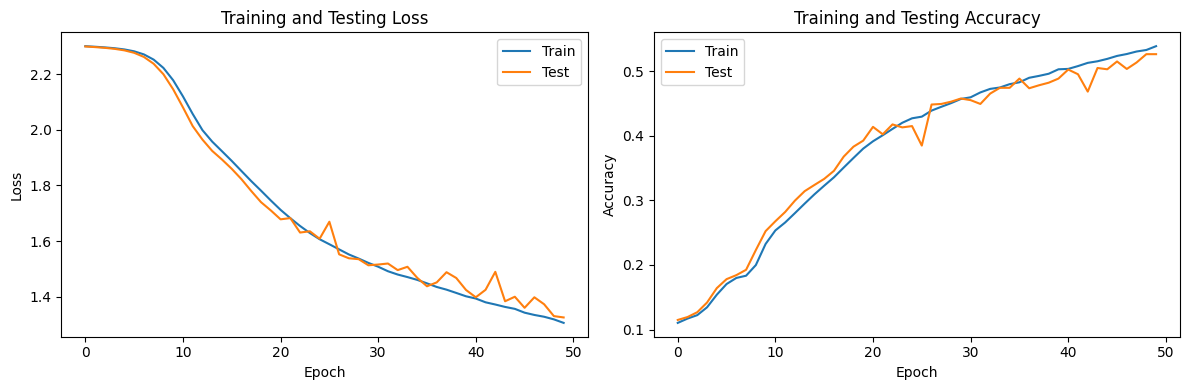

In [ ]:
# Architecture 2, Learning Rate 1, Optimizer 2
train_cifar_10(model2_architecture2_2, train_ds, test_ds, NUM_EPOCHS, LR1, SGD2_1)  # Setting 6

Epoch 1, Loss: 3.3018, Accuracy: 20.23%, Test Loss: 1.9219, Test Accuracy: 30.05%
Epoch 2, Loss: 1.7921, Accuracy: 33.10%, Test Loss: 1.7071, Test Accuracy: 35.91%
Epoch 3, Loss: 1.6443, Accuracy: 38.98%, Test Loss: 1.5856, Test Accuracy: 40.39%
Epoch 4, Loss: 1.5812, Accuracy: 41.86%, Test Loss: 1.5948, Test Accuracy: 41.93%
Epoch 5, Loss: 1.5185, Accuracy: 44.24%, Test Loss: 1.4854, Test Accuracy: 45.73%
Epoch 6, Loss: 1.4762, Accuracy: 45.91%, Test Loss: 1.4481, Test Accuracy: 47.16%
Epoch 7, Loss: 1.4449, Accuracy: 47.25%, Test Loss: 1.4420, Test Accuracy: 47.89%
Epoch 8, Loss: 1.4340, Accuracy: 47.90%, Test Loss: 1.4061, Test Accuracy: 48.87%
Epoch 9, Loss: 1.4110, Accuracy: 48.93%, Test Loss: 1.4113, Test Accuracy: 48.68%
Epoch 10, Loss: 1.3869, Accuracy: 49.81%, Test Loss: 1.4319, Test Accuracy: 48.44%
Epoch 11, Loss: 1.3821, Accuracy: 49.89%, Test Loss: 1.4161, Test Accuracy: 48.85%
Epoch 12, Loss: 1.3757, Accuracy: 50.37%, Test Loss: 1.3810, Test Accuracy: 50.41%
Epoch 13, Los

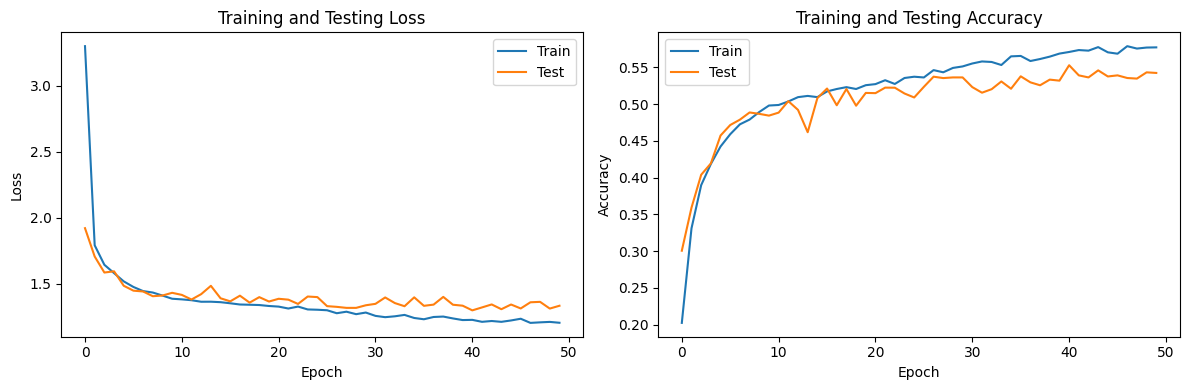

In [ ]:
# Architecture 2, Learning Rate 2, Optimizer 1
train_cifar_10(model2_architecture2_3, train_ds, test_ds, NUM_EPOCHS, LR2, adam2_2)  # Setting 7

Epoch 1, Loss: 2.2951, Accuracy: 12.40%, Test Loss: 2.2784, Test Accuracy: 12.26%
Epoch 2, Loss: 2.0828, Accuracy: 24.87%, Test Loss: 1.9496, Test Accuracy: 27.43%
Epoch 3, Loss: 1.7753, Accuracy: 36.32%, Test Loss: 1.6666, Test Accuracy: 38.84%
Epoch 4, Loss: 1.5931, Accuracy: 42.57%, Test Loss: 1.5331, Test Accuracy: 43.63%
Epoch 5, Loss: 1.4785, Accuracy: 46.83%, Test Loss: 1.4216, Test Accuracy: 47.15%
Epoch 6, Loss: 1.3965, Accuracy: 49.99%, Test Loss: 1.4061, Test Accuracy: 49.89%
Epoch 7, Loss: 1.3170, Accuracy: 52.86%, Test Loss: 1.2599, Test Accuracy: 54.01%
Epoch 8, Loss: 1.2399, Accuracy: 55.68%, Test Loss: 1.2457, Test Accuracy: 54.38%
Epoch 9, Loss: 1.1674, Accuracy: 58.58%, Test Loss: 1.2771, Test Accuracy: 54.12%
Epoch 10, Loss: 1.1072, Accuracy: 60.86%, Test Loss: 1.1513, Test Accuracy: 58.55%
Epoch 11, Loss: 1.0434, Accuracy: 63.36%, Test Loss: 1.0648, Test Accuracy: 61.86%
Epoch 12, Loss: 0.9846, Accuracy: 65.40%, Test Loss: 1.0815, Test Accuracy: 61.66%
Epoch 13, Los

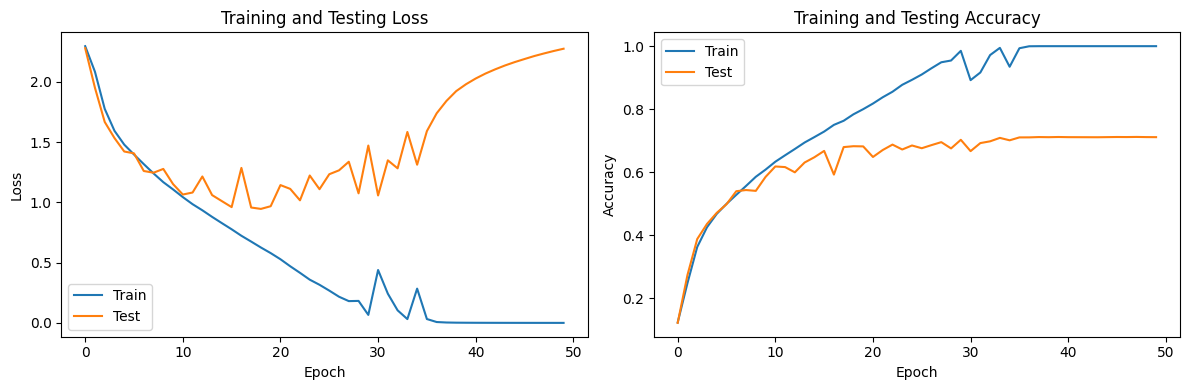

In [ ]:
# Architecture 2, Learning Rate 2, Optimizer 2
train_cifar_10(model2_architecture2_4, train_ds, test_ds, NUM_EPOCHS, LR2, SGD2_2)  # Setting 8